In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

import bilby
import pycbc
import pickle
import deepdish
import pycbc.psd
import pycbc.types
import gwpopulation
import pycbc.waveform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')
rc('font', serif='times')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines", linewidth=1)
rc('axes', labelsize=25) #24
rc("axes", linewidth=1) #2)
rc('xtick', labelsize=24)
rc('ytick', labelsize=24)
rc('legend', fontsize=20) #16
rc('ytick', right='True',direction= 'in')
rc('xtick', top='True',direction= 'in')
rc('xtick.major', pad=22) #8)
rc('ytick.major', pad=22) #8)
rc('xtick.major', size=22) #8)
rc('ytick.major', size=22) #8)
rc('xtick.minor', size=20) #8)
rc('ytick.minor', size=20) #8)
rc('axes', titlesize=27) #24)
rc('figure', titlesize=27) #24)
rc('axes', labelpad=10) #24)

def set_tick_sizes(ax, major, minor):
    for l in ax.get_xticklines() + ax.get_yticklines():
        l.set_markersize(major)
    for tick in ax.xaxis.get_minor_ticks() + ax.yaxis.get_minor_ticks():
        tick.tick1line.set_markersize(minor)
        tick.tick2line.set_markersize(minor)
    ax.xaxis.LABELPAD=10.
    ax.xaxis.OFFSETTEXTPAD=10.

In [3]:
delta_f = 1
duration = 100
minimum_frequency = 20
reference_frequency = 50   # Most sensitive frequency
maximum_frequency = 1024
sampling_frequency = 2048

### Population

In [4]:
injection = deepdish.io.load('../../src/output/injections/injections.hdf5')['injections']

for key, val in injection.items():   # Setting the variables
    exec(key + '=val')

data = np.loadtxt('../../src/output/injections/snr.csv', delimiter=',')
det_idx, snr_det = data[:,0], data[:,1]

num_points = int(len(det_idx) / 2)
idxs = np.random.choice(len(det_idx), size=(num_points, 2), replace=False)

unique_idxs, counts = np.unique(idxs[:, 0], return_counts=True)
mask = counts == 1
filtered_idxs = idxs[mask]

In [5]:
mchirp = (mass_1*mass_2)**(3/5)/(mass_1+mass_2)**(1/5)

mchirpratio, snrratio, delta_tc = np.array([]), np.array([]), np.array([])
mchirpratio_cut, snrratio_cut, delta_tc_cut = np.array([]), np.array([]), np.array([])

for i in range(filtered_idxs.shape[0]):
    mchirp_ratio = mchirp[det_idx[filtered_idxs[i, 0]]] / mchirp[det_idx[filtered_idxs[i, 1]]]
    snr_ratio = snr_det[filtered_idxs[i, 0]] / snr_det[filtered_idxs[i, 1]]
    delta_tc_value = np.random.uniform(-2, 2)

    mchirpratio = np.append(mchirpratio, mchirp_ratio)
    snrratio = np.append(snrratio, snr_ratio)
    delta_tc = np.append(delta_tc, delta_tc_value)

    if 0.5 <= mchirp_ratio <= 2 and 0.5 <= snr_ratio <= 2:
        mchirpratio_cut = np.append(mchirpratio_cut, mchirp_ratio)
        snrratio_cut = np.append(snrratio_cut, snr_ratio)
        delta_tc_cut = np.append(delta_tc_cut, delta_tc_value)

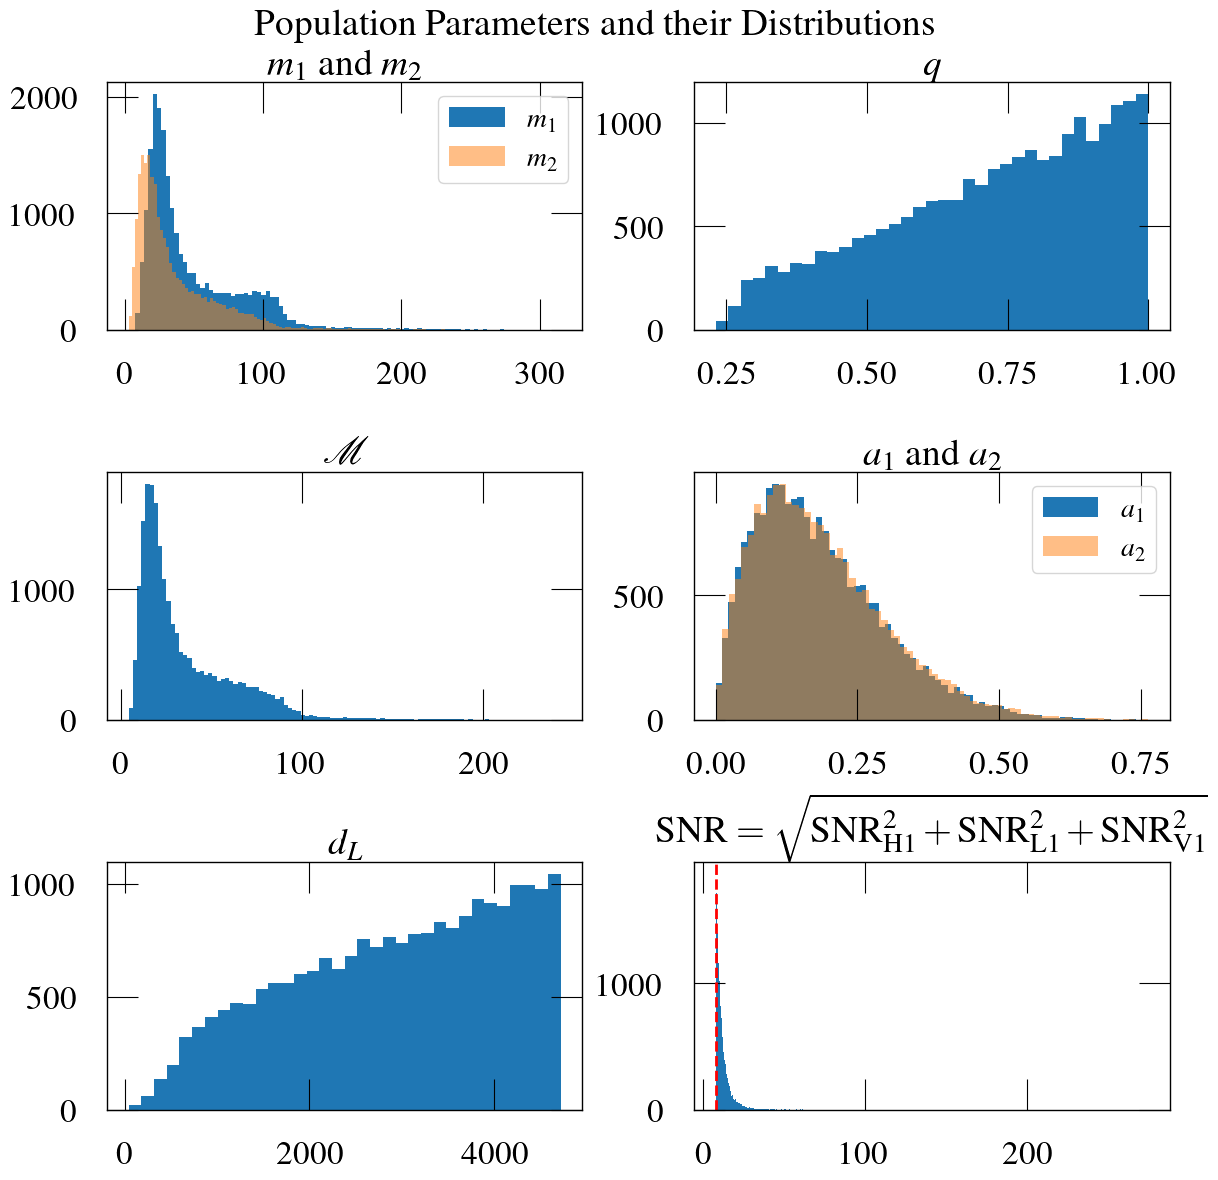

In [6]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

axs[0, 0].hist(mass_1[det_idx], bins='auto', label='$m_1$')
axs[0, 0].hist(mass_2[det_idx], bins='auto', label='$m_2$', alpha=0.5)
axs[0, 0].set_title('$m_1$ and $m_2$')
axs[0, 0].legend()

axs[0, 1].hist(mass_ratio[det_idx], bins='auto')
axs[0, 1].set_title('$q$')

axs[1, 0].hist(mchirp[det_idx], bins='auto')
axs[1, 0].set_title('$\\mathcal{M}$')

axs[1, 1].hist(a_1[det_idx], bins='auto', label='$a_1$')
axs[1, 1].hist(a_2[det_idx], bins='auto', label='$a_2$', alpha=0.5)
axs[1, 1].set_title('$a_1$ and $a_2$')
axs[1, 1].legend()

axs[2, 0].hist(luminosity_distance[det_idx], bins='auto')
axs[2, 0].set_title('$d_L$')
axs[2, 0].ticklabel_format(useOffset=False, style='plain')

axs[2, 1].hist(snr_det, bins='auto')
axs[2, 1].set_title('$\\mathrm{SNR}=\\sqrt{\\mathrm{SNR}_{\\mathrm{H1}}^2+\\mathrm{SNR}_{\\mathrm{L1}}^2+\\mathrm{SNR}_{\\mathrm{V1}}^2}$')
axs[2, 1].axvline(8, linewidth=2, ls='--', color='r')

plt.suptitle('Population Parameters and their Distributions')

fig.tight_layout()
plt.show()

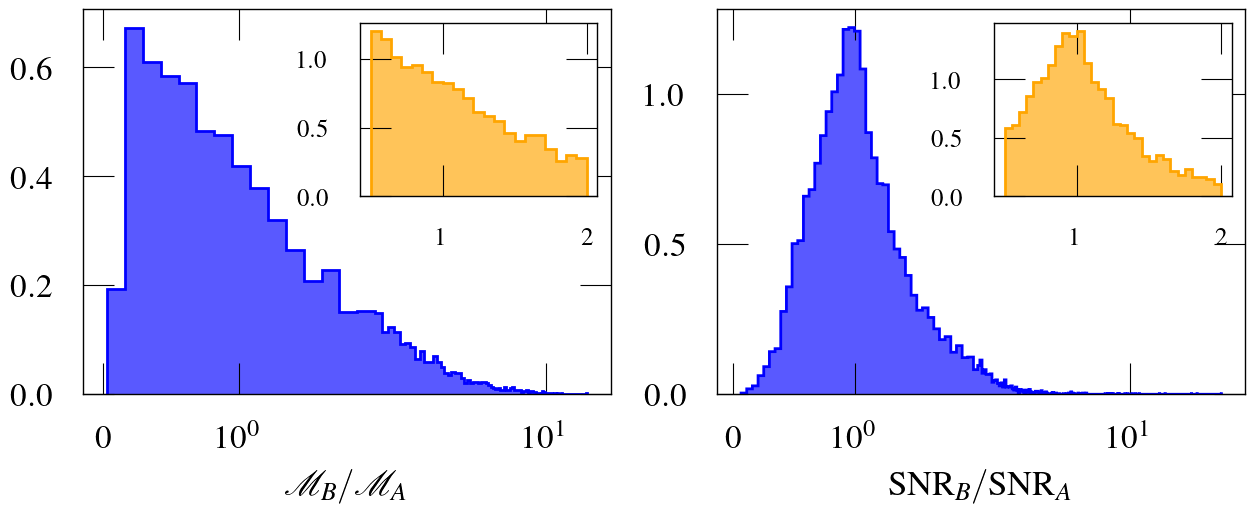

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].hist(mchirpratio, bins='auto', histtype='step', lw=2, color='blue', density=True)
axs[0].hist(mchirpratio, bins='auto', histtype='stepfilled', alpha=0.65, color='blue', density=True)

axs[0].set_xlabel('$\\mathcal{M}_B/\\mathcal{M}_A$')
axs[0].set_xscale('symlog')

ax_inset1 = inset_axes(axs[0], width="45%", height="45%", loc='upper right')
ax_inset1.hist(mchirpratio_cut, bins='auto', histtype='step', lw=2, color='orange', density=True)
ax_inset1.hist(mchirpratio_cut, bins='auto', histtype='stepfilled', alpha=0.65, color='orange', density=True)
ax_inset1.tick_params(labelsize=18)

axs[1].hist(snrratio, bins='auto', histtype='step', lw=2, color='blue', density=True)
axs[1].hist(snrratio, bins='auto', histtype='stepfilled', alpha=0.65, color='blue', density=True)

axs[1].set_xlabel('$\\mathrm{SNR}_B/\\mathrm{SNR}_A$')
axs[1].set_xscale('symlog')

ax_inset2 = inset_axes(axs[1], width="45%", height="45%", loc='upper right')
ax_inset2.hist(snrratio_cut, bins='auto', histtype='step', lw=2, color='orange', density=True)
ax_inset2.hist(snrratio_cut, bins='auto', histtype='stepfilled', alpha=0.65, color='orange', density=True)
ax_inset2.tick_params(labelsize=18)

plt.savefig('../../plots/PopulationParameters.pdf', dpi=300, bbox_inches='tight')
plt.show()